## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

## Dataset

In [2]:
df = pd.read_csv("Social_Network_Ads.csv")

In [3]:
df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
User ID            400 non-null int64
Gender             400 non-null object
Age                400 non-null int64
EstimatedSalary    400 non-null int64
Purchased          400 non-null int64
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


## Splitting dataset

In [5]:
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Statistics

In [7]:
qualitative = [column for column in X.columns if X[column].dtype=="object"]
quantitative = [column for column in X.columns if column not in qualitative]

In [8]:
X_train[quantitative].describe()

,Age,EstimatedSalary
count,300.000000,300.000000
mean,38.126667,69583.333333
std,10.114592,34548.541619
min,18.000000,15000.000000
25%,30.750000,43000.000000
50%,38.000000,69500.000000
75%,46.000000,88000.000000
max,60.000000,150000.000000


In [9]:
X_train[qualitative].describe()

,Gender
count,300
unique,2
top,Female
freq,153


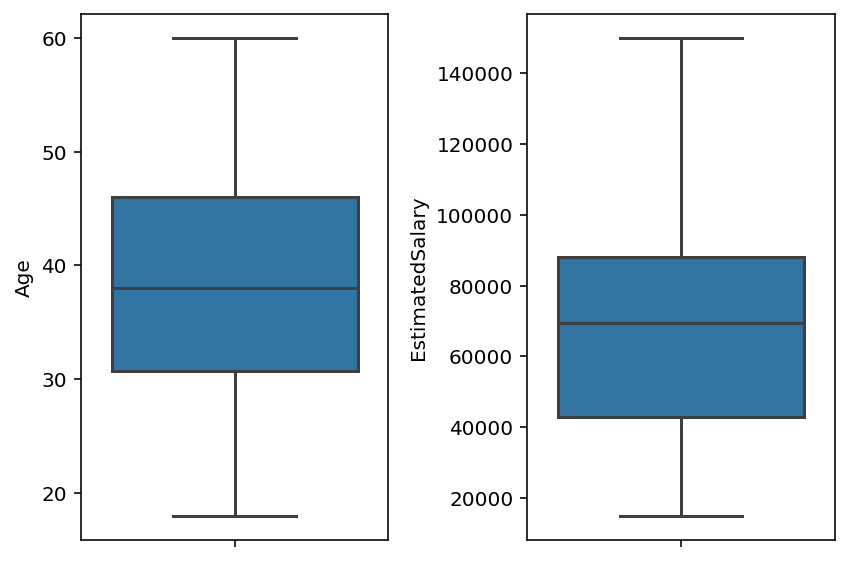

In [10]:
n = len(quantitative)
rows = (n+1)//2
cols = 2

fig, ax = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        try:
            sns.boxplot(y=quantitative[2*i+j], data=X_train, ax=ax[i][j])
        except:
            sns.boxplot(y=quantitative[2*i+j], data=X_train, ax=ax[j])
plt.tight_layout()
plt.show()

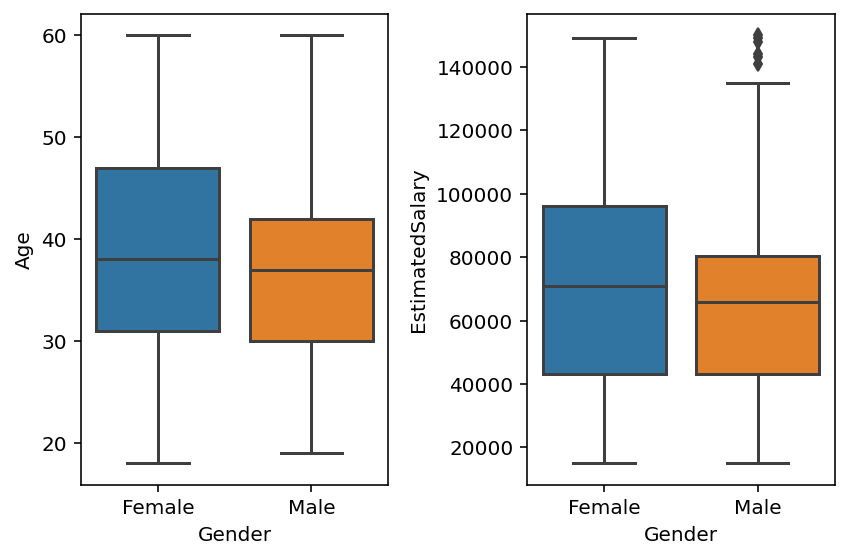

In [11]:
n = len(quantitative)
rows = (n+1)//2
cols = 2

fig, ax = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        try:
            sns.boxplot(x="Gender", y=quantitative[2*i+j], data=X_train, ax=ax[i][j])
        except:
            sns.boxplot(x="Gender", y=quantitative[2*i+j], data=X_train, ax=ax[j])
plt.tight_layout()
plt.show()

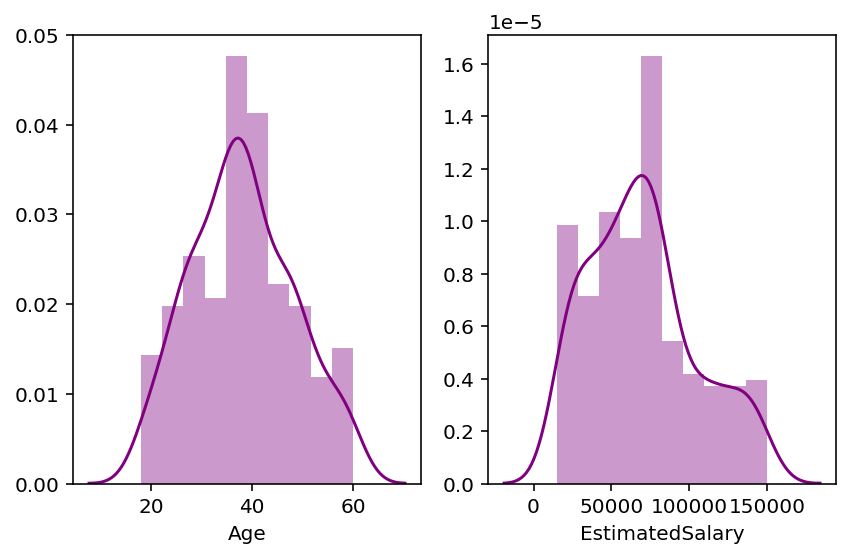

In [12]:
n = len(quantitative)
rows = (n+1)//2
cols = 2

fig, ax = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        try:
            sns.distplot(X_train[quantitative[2*i+j]], color="purple", ax=ax[i][j])
        except:
            sns.distplot(X_train[quantitative[2*i+j]], bins=10, color="purple", ax=ax[j])
plt.tight_layout()
plt.show()

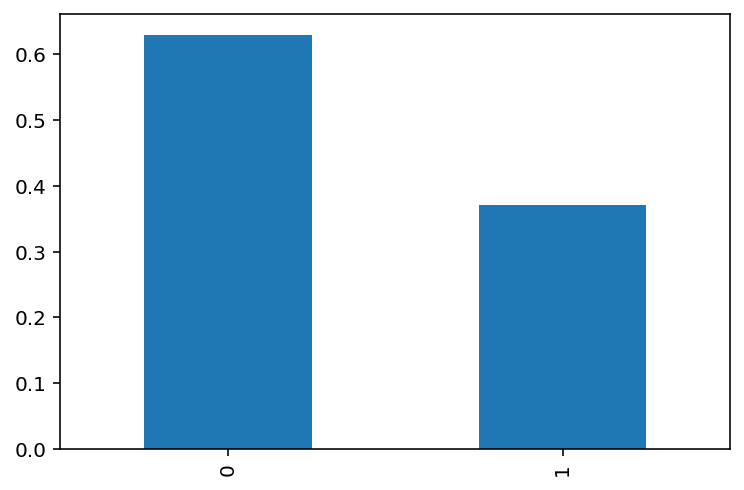

In [13]:
(y_train.value_counts()/y_train.shape).plot(kind="bar")
plt.show()

## Building Reduced Model

In [14]:
X_train_red, X_test_red = X_train.iloc[:, 1:], X_test.iloc[:, 1:]

+ Pipeline

In [15]:
model = Pipeline(steps=[
    ("standardization", StandardScaler()),
    ("svm", SVC(C=1.0, kernel="rbf", probability=True, random_state=0))
])

In [16]:
model.fit(X_train_red, y_train)

Pipeline(memory=None,
         steps=[('standardization',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1, probability=True,
                     random_state=0, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [17]:
y_pred = model.predict(X_test_red)

+ Metrics

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        68
           1       0.88      0.91      0.89        32

    accuracy                           0.93       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.93      0.93      0.93       100



In [19]:
y_predicted = pd.DataFrame(data=y_pred, index=y_test.index, columns=["Predicted"])
complete = pd.merge(left=y_test, right=y_predicted, right_index=True, left_index=True)

complete["Purchased"] = complete["Purchased"].apply(lambda x: "Yes" if x==1 else "No")
complete["Predicted"] = complete["Predicted"].apply(lambda x: "Yes" if x==1 else "No")

conf_matrix = complete.groupby(["Purchased", "Predicted"]).size().unstack("Predicted")
conf_matrix

Predicted,No,Yes
Purchased,,
No,64,4
Yes,3,29


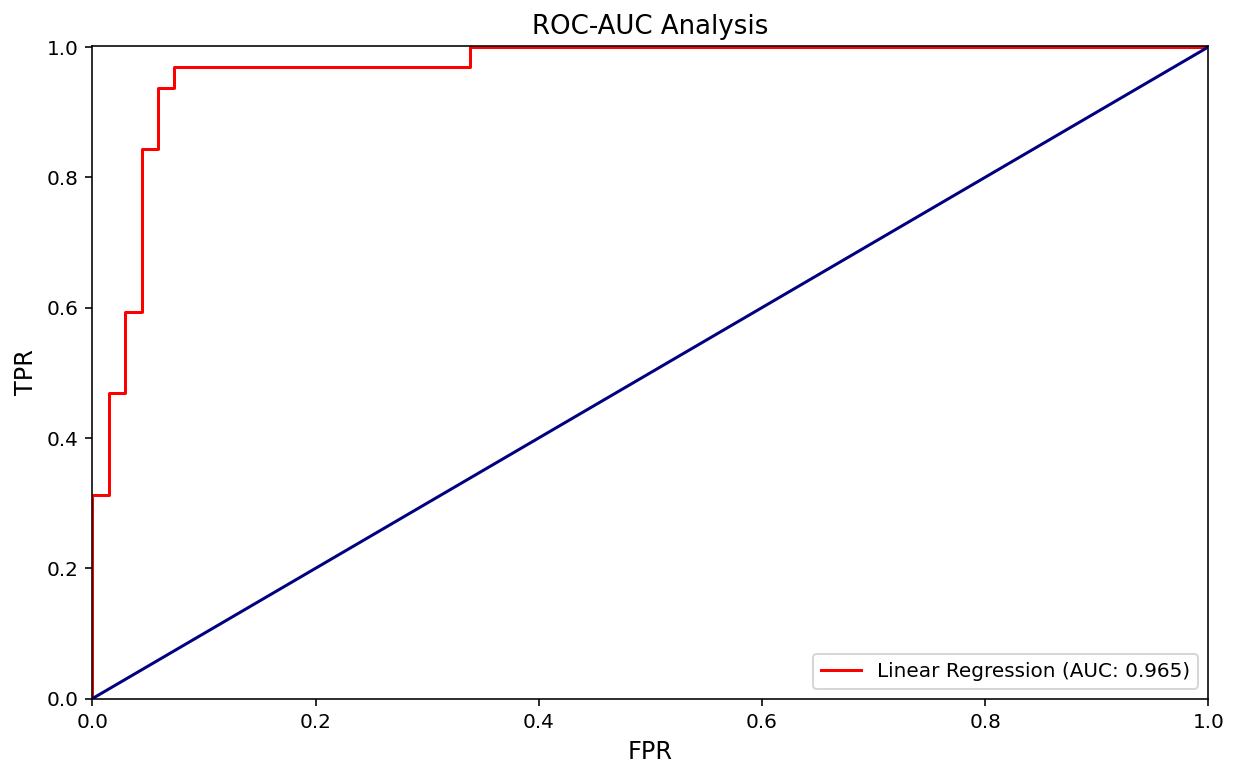

In [20]:
probabilities = model.predict_proba(X_test_red)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.plot(fpr, tpr, color="red", label=f"Linear Regression (AUC: {roc_auc_score(y_test, probabilities):.3f})")
plt.plot([0,1], [0,1], color="navy")
plt.xlabel("FPR", fontsize=12)
plt.ylabel("TPR", fontsize=12)
plt.xlim((0,1))
plt.ylim((0,1.001))
plt.legend(loc=4, fontsize=10)
plt.title("ROC-AUC Analysis", fontsize=13)
plt.show()

+ Visualizing Decision Boundary:

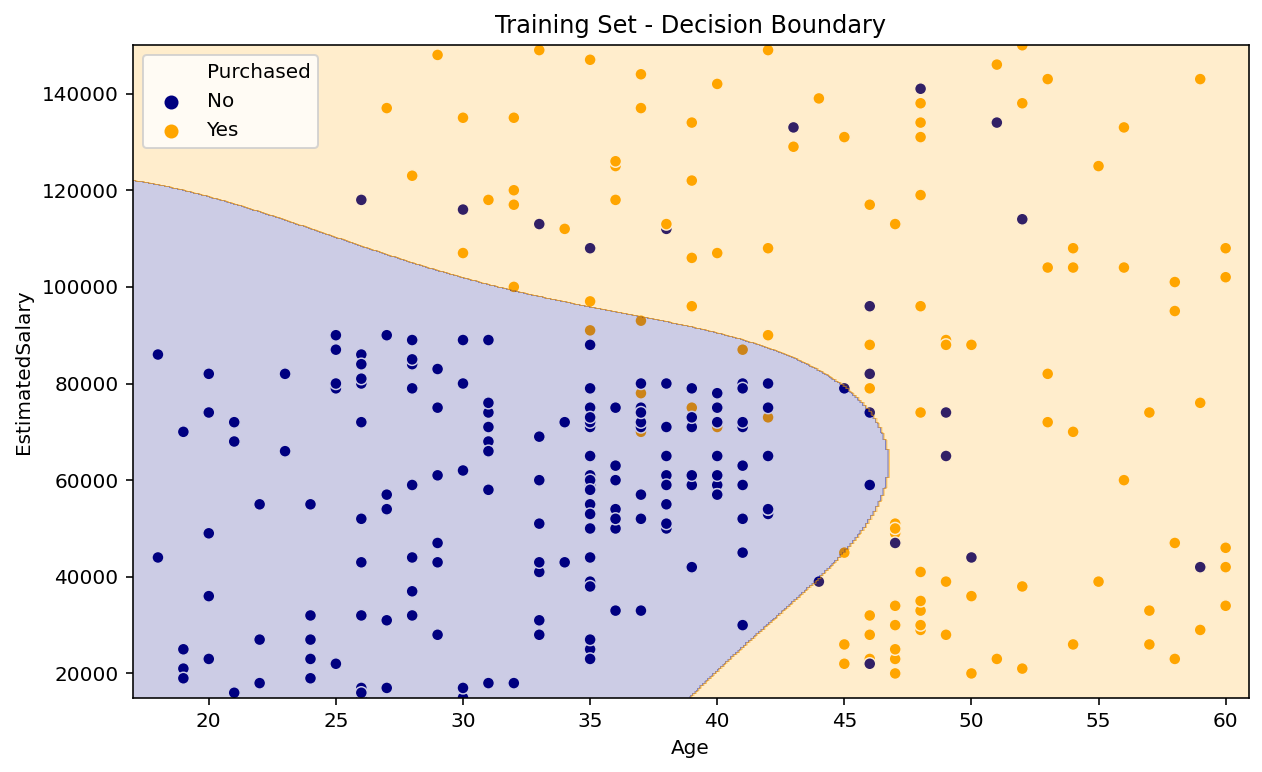

In [21]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.scatterplot(X_train_red.iloc[:,0], X_train_red.iloc[:,1], 
                    hue=y_train.apply(lambda x: "Yes" if x==1 else "No"), palette=["navy", "orange"], ax=ax)
xx, yy = np.mgrid[X_train_red.iloc[:,0].min()-1:X_train_red.iloc[:,0].max()+1:.1,
                  X_train_red.iloc[:,1].min()-1:X_train_red.iloc[:,1].max()+1:100]
grid = np.c_[xx.ravel(), yy.ravel()]
classes = model.predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, classes, cmap=ListedColormap(("navy", "orange")), alpha=0.2)
ax.set_title("Training Set - Decision Boundary")
plt.show()

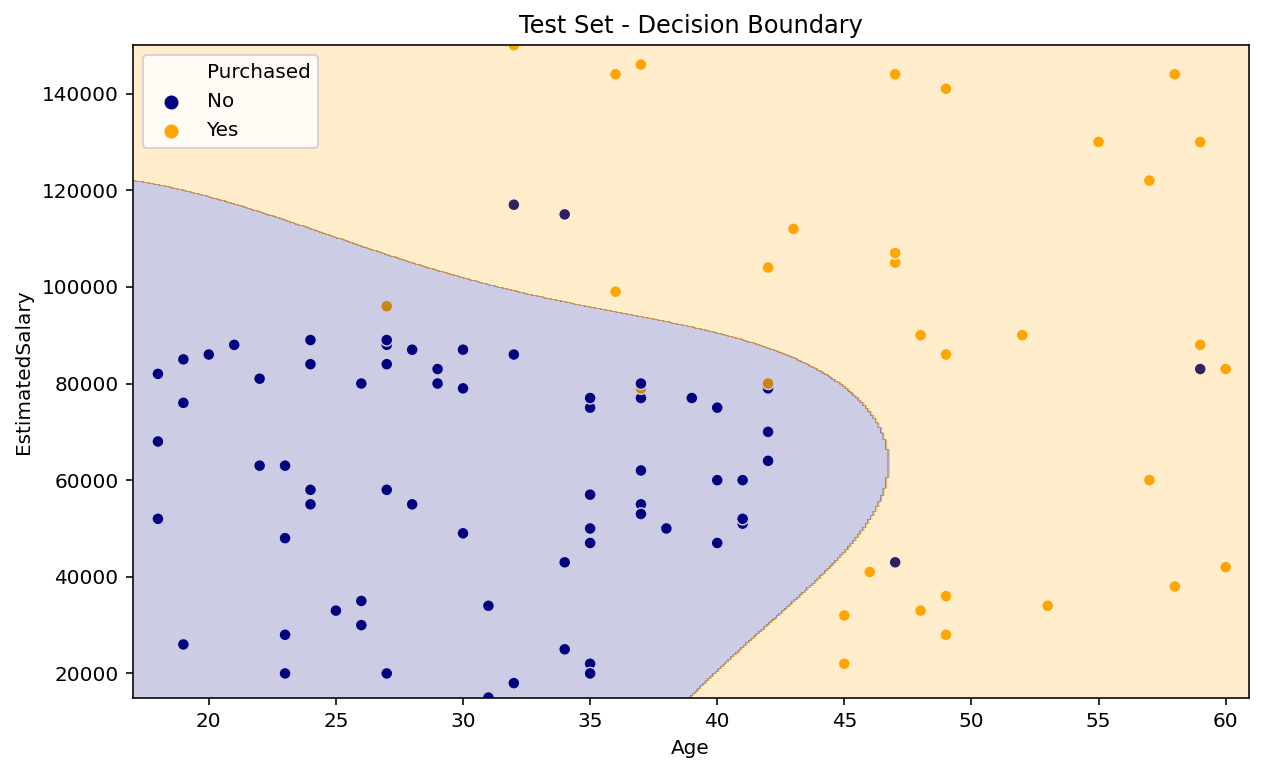

In [22]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.scatterplot(X_test_red.iloc[:,0], X_test_red.iloc[:,1], 
                    hue=y_test.apply(lambda x: "Yes" if x==1 else "No"), palette=["navy", "orange"], ax=ax)
xx, yy = np.mgrid[X_test_red.iloc[:,0].min()-1:X_test_red.iloc[:,0].max()+1:.1,
                  X_test_red.iloc[:,1].min()-1:X_test_red.iloc[:,1].max()+1:100]
grid = np.c_[xx.ravel(), yy.ravel()]
classes = model.predict(grid).reshape(xx.shape)
ax.contourf(xx, yy, classes, cmap=ListedColormap(("navy", "orange")), alpha=0.2)
ax.set_title("Test Set - Decision Boundary")
plt.show()

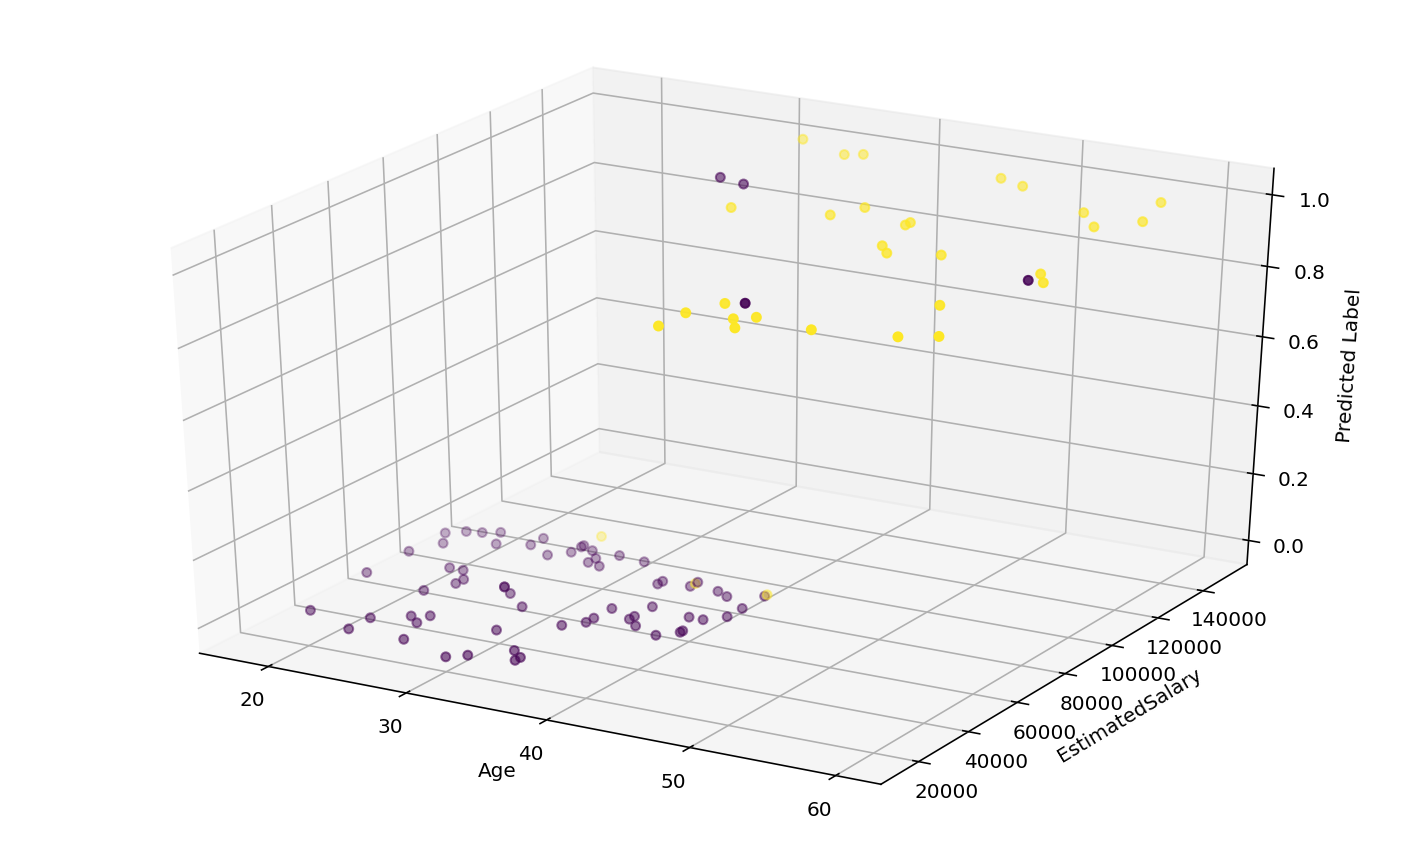

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

x = X_test_red.iloc[:,0]
y = X_test_red.iloc[:,1]
z = y_pred

ax.scatter(x, y, z, c=y_test, marker='o')

ax.set_xlabel('Age')
ax.set_ylabel('EstimatedSalary')
ax.set_zlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Complete Model

In [24]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, data, labels=None):
        return self
    
    def transform(self, data):
        assert isinstance(data, pd.DataFrame), "Insert a pandas dataframe."
        
        return data[self.columns]

In [25]:
num_preprocessor = Pipeline(steps=[
    ("num_selector", ColumnSelector(columns=quantitative)),
    ("standardization", StandardScaler())])
cat_preprocessor = Pipeline(steps=[
    ("cat_selector", ColumnSelector(columns=qualitative)),
    ("onehot", OneHotEncoder())])
preprocessor = FeatureUnion(transformer_list=[("categorical", cat_preprocessor), ("numerical", num_preprocessor)])

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("svm", SVC(C=1.0, kernel="rbf", probability=True, random_state=0))])

In [26]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical',
                                                 Pipeline(memory=None,
                                                          steps=[('cat_selector',
                                                                  ColumnSelector(columns=['Gender'])),
                                                                 ('onehot',
                                                                  OneHotEncoder(categories='auto',
                                                                                drop=None,
                                                                                dtype=<class 'numpy.float64'>,
                                                                                handle_unknown='error',
                                                                                sparse=True))],
     

In [27]:
y_pred = model.predict(X_test)

+ Metrics

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        68
           1       0.88      0.91      0.89        32

    accuracy                           0.93       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.93      0.93      0.93       100



In [29]:
y_predicted = pd.DataFrame(data=y_pred, index=y_test.index, columns=["Predicted"])
complete = pd.merge(left=y_test, right=y_predicted, right_index=True, left_index=True)

complete["Purchased"] = complete["Purchased"].apply(lambda x: "Yes" if x==1 else "No")
complete["Predicted"] = complete["Predicted"].apply(lambda x: "Yes" if x==1 else "No")

conf_matrix = complete.groupby(["Purchased", "Predicted"]).size().unstack("Predicted")
conf_matrix

Predicted,No,Yes
Purchased,,
No,64,4
Yes,3,29


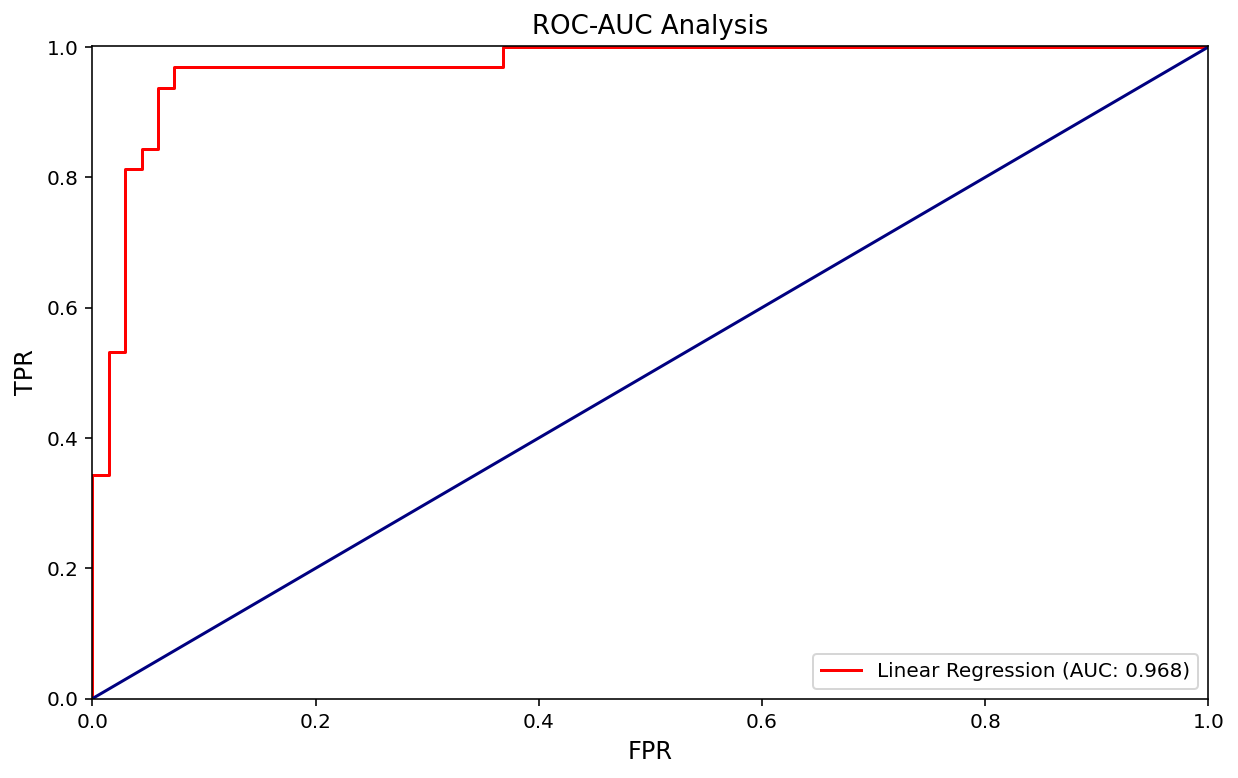

In [30]:
probabilities = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

fig, ax = plt.subplots(1,1, figsize=(10,6))
plt.plot(fpr, tpr, color="red", label=f"Linear Regression (AUC: {roc_auc_score(y_test, probabilities):.3f})")
plt.plot([0,1], [0,1], color="navy")
plt.xlabel("FPR", fontsize=12)
plt.ylabel("TPR", fontsize=12)
plt.xlim((0,1))
plt.ylim((0,1.001))
plt.legend(loc=4, fontsize=10)
plt.title("ROC-AUC Analysis", fontsize=13)
plt.show()